In [2]:
import pandas as pd
import numpy as np
from DataGenerator import TimeSeriesGenerator, generateTrend, generateSeasonality, suddenDrift, incrementalDrift
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from TimeSeriesGradientBoosting import TimeSeriesGradientBoosting
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
pd.options.plotting.backend = "plotly"

### introduction

The following notebook demonstrates the overall goals of the thesis and explains the steps required to generate a time series using the 'TimeSeriesGenerator' class. The notebook was written early into the project and is not up to date anymore, however it is still a useful starting point to get started with using the 'TimeSeriesGenerator' class.

If there is sufficient interest, the notebook can be updated to reflect the current state of the project and the current state of the code. The notebook is also a good starting point for the development of the 'TImeSeriesGenerator' class. Certain changes need to to be made to it such as support for binary variables, holiday effects and most importantly, adding trend and seasonality not happening in place.

# Linear time series

A linear time series can be written as: $$ y_{t} = C_{t} \cdot X_{t}$$ 
With $C_{t}$ being hidden coefficients and $X_{t}$ being observable variables such that:

$$ Y_{t} = \sum_{i=1}^n c_{it} * x_{it}$$

The main idea behind our experimental setup is that the models are only given $X_{t}$ and essentially have to learn something that closely *mimics* $C_{t}$. 

We can directly introduce drift by changing $C$ as from a certain timepoint $T=t$. Our main assumption is that given a change in $C_{t}$ there are sufficient strategies to reduce the negative impact on $\hat{y}_{t}$, this is not our immediate focus.

We want to introduce drift in the aforementioned way *and* remove corresponding variable from the dataset that is given to the learner. Our goals are threefold:

- Can we identify when drift occurs?
- If so, can we find solutions to mitigate the impact of drift in the short term?
- Both being true: can this inform us on the optimal way and time to retrain our model(s)?

To achieve this we made a `TimeSeriesGenerator` class that allows us to generate time series in the form specified above.

With the current seed the hidden coefficients of the variables are as follows (with seed 42): 

`[0.97562235, 0.7611397 , 0.78606431, 0.12811363, 0.45038594, 0.37079802, 0.92676499, 0.64386512, 0.82276161, 0.4434142]`

The initial values for the time series are:
`[8, 77, 65, 43, 43, 85,  8, 69, 20,  9]`

At each time step these base values are multiplied by a random number uniformly sampled from $[0.99, 1.04[$. 

This result represents the observable values $X_{t}$, $X_{t}$ is then multiplied by the hidden coefficients to produce $Y_{t}$ after the errors have been added.

Additionally the `generateTrend()`, `generateSeasonality()` can add trend and/or seasonality to any number of variables.
## No drift

The first case is a time series with additive trend and seasonality.


In [3]:
WithoutDrift = TimeSeriesGenerator(size=4000, amountOfVariables=10, seed=42)
generateTrend(WithoutDrift,[0,2], [2,4])
generateSeasonality(WithoutDrift, periods=2, indices=0)
WithoutDrift_df = WithoutDrift.toDataFrame(frequency='D')
WithoutDrift_df.head()

,Variable_0,Variable_1,Variable_2,Variable_3,Variable_4,Variable_5,Variable_6,Variable_7,Variable_8,Variable_9,Response,year,week,day
2017-01-01,22.251854,25.125913,46.394825,17.914757,18.598972,27.089149,11.017634,23.204532,14.617991,11.415668,153.254048,2016,52,7
2017-01-02,22.896337,25.727944,46.702086,18.338433,18.797601,27.557621,11.124340,23.653718,14.318757,10.971853,158.832298,2017,1,1
2017-01-03,22.911527,25.219988,46.973139,18.229150,18.707280,27.446671,11.387310,22.956689,14.636706,11.207170,153.423019,2017,1,2
2017-01-04,23.203838,25.112234,46.187570,18.216062,18.594921,28.268357,11.331565,23.525089,14.236822,11.436608,161.141438,2017,1,3
2017-01-05,23.971843,25.189557,47.154737,18.246725,18.684084,28.296248,11.354414,22.992940,14.352355,10.968393,160.665571,2017,1,4


In [20]:
base = TimeSeriesGenerator(size=365, amountOfVariables=10, seed=42)
noTrendSeason_df = TimeSeriesGenerator(size=365, amountOfVariables=10, seed=10).toDataFrame()
generateSeasonality(base, periods=6, indices=2)
generateTrend(base,1, 2)
trendSeason = base.toDataFrame(frequency='D')
base = TimeSeriesGenerator(size=365, amountOfVariables=10, seed=10)
generateSeasonality(base, periods=6, indices=2)
generateTrend(base,1, 2)
suddenDrift(base, 0, 289, 3)
suddenDrift_df = base.toDataFrame(frequency='D')
base = TimeSeriesGenerator(size=365, amountOfVariables=10, seed=10)
generateSeasonality(base, periods=6, indices=2)
generateTrend(base,1, 2)
incrementalDrift(base, [289, 319], 0, 3)
incrementalDrift_df = base.toDataFrame(frequency='D')


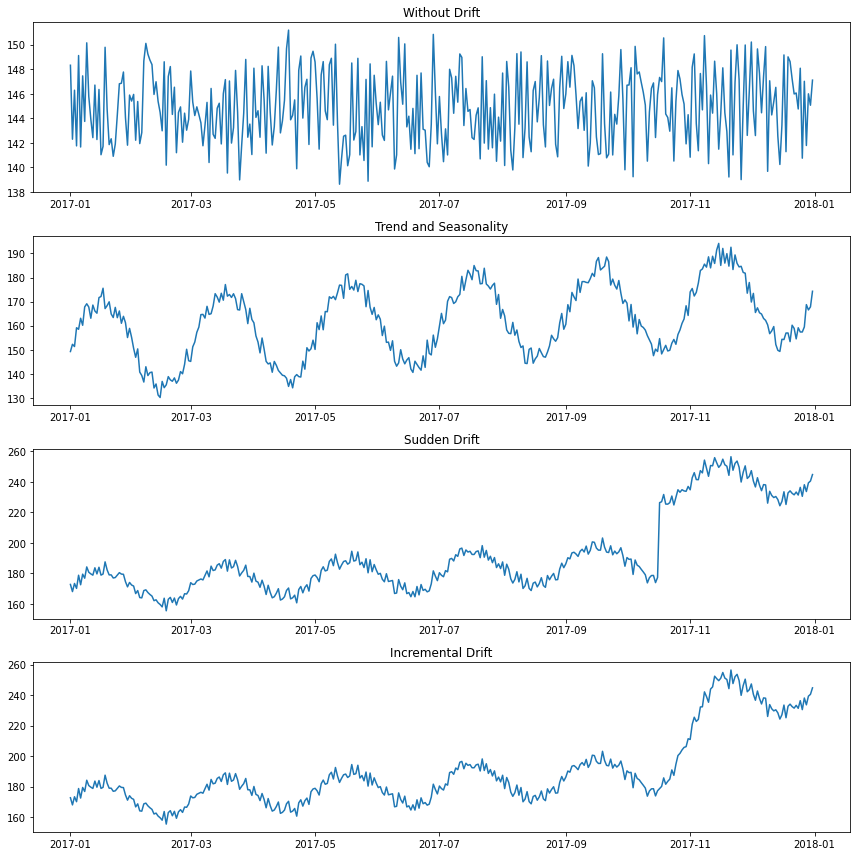

In [22]:
# Make a figure with four subplots with a shared x axis
fig, ax = plt.subplots(4, 1, figsize=(12 , 12))
# Plot the time series
ax[0].plot(noTrendSeason_df['Response'])
ax[0].set_title('Without Drift')
ax[1].plot(trendSeason['Response'])
ax[1].set_title('Trend and Seasonality')
ax[2].plot(suddenDrift_df['Response'])
ax[2].set_title('Sudden Drift')
ax[3].plot(incrementalDrift_df['Response'])
ax[3].set_title('Incremental Drift')
fig.tight_layout()
plt.show()

In [8]:
fig = px.line(WithoutDrift_df,x=WithoutDrift_df.index, y="Response", title = f"Seasonal time series with {WithoutDrift_df.shape[0]} observations")
fig.update_layout(title_x = 0.5)
fig.show()

### Baseline: Model with full knowledge

In [9]:
X = WithoutDrift_df.drop("Response", axis="columns")
y = WithoutDrift_df["Response"].copy()
timeSeriesSPlits = TimeSeriesSplit(
    n_splits=5,
    gap=20,
    max_train_size=3000,
    test_size=200,
)

all_splits = list(timeSeriesSPlits.split(X, y))
train_0, test_0 = all_splits[0]

In [27]:
GBR_pipeline = make_pipeline(HistGradientBoostingRegressor())
RF_pipeline = make_pipeline(RandomForestRegressor())
tsgb = TimeSeriesGradientBoosting(LinearRegression(), HistGradientBoostingRegressor())
TSGB_pipeline = make_pipeline(tsgb)

In [11]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

In [12]:
evaluate(GBR_pipeline, X, y, cv=timeSeriesSPlits)

Mean Absolute Error:     6.570 +/- 1.065
Root Mean Squared Error: 7.609 +/- 1.173


In [13]:
evaluate(RF_pipeline, X, y, cv=timeSeriesSPlits)

Mean Absolute Error:     7.438 +/- 1.693
Root Mean Squared Error: 8.542 +/- 1.777


In [33]:
GBR_pipeline.fit(X.iloc[:-200], y.iloc[:-200])
GBR_predictions = pd.Series(GBR_pipeline.predict(X.iloc[-200:]))
#GBR_residuals = y.iloc[:-200] - GBR_predictions

tsgb.fit(X.iloc[:-200], X.iloc[:-200], y.iloc[:-200])
RF_predictions = pd.Series(tsgb.predict(X.iloc[-200:], X.iloc[-200:]))

SES_predictions = SimpleExpSmoothing(y).fit(smoothing_level=1).predict(-200, None)
SES_residuals = SimpleExpSmoothing(y).fit(smoothing_level=1).resid

predictions = pd.concat([y.iloc[-200:].reset_index(), GBR_predictions, RF_predictions, SES_predictions.reset_index(drop=True)], axis = 1)
predictions = predictions.set_index("index")
predictions = predictions.rename({0: "Gradient_boosted_tree", 1 : "Time series Gradient Boosting", 2: "Exponential smoothing"}, axis =1)

In [34]:
fig = predictions.plot(template="simple_white", title = "Full knowledge no drift")
fig.update_traces(mode='markers+lines')
fig.update_layout(title_x = 0.5)
fig.show()

In [35]:
SES_MAE = np.mean(np.abs(SES_residuals))
print(f"The MAE of SES is {SES_MAE}")

The MAE of SES is 3.836326223511656


#### Discussion

Both tree based models work pretty well out of the box as they have no problems capturing non-linear effects. A simple exponential smoothing model with α = 1 simply predicts the previous value at each time step. Currently as there are no strong deviations (e.g. one day having a significantly higher/lower level of sales) that punish this behaviour.

**Before we move to the case without full knowledge we need to make the data generator better. SES will outperform RF and GBRT since it only uses Y values either way.** 

Ways to improve the generation process: 

- ~~Include days of the week as a dummy variable and include coefficients for it. It should be lower on certain days.~~ This has been implemented through the `weeklyPattern()`method.
- Same could be done for months.
- The next y-value could *explicitly* be a function of the previous one. This is currently not the case.
- Suggestions?

Additional note: 
We ran this on different seeds. On some seeds both tree-based models immediately outperformed $SES_{\alpha=1}$ without using `weeklyPattern()`.

#### Adjustment to TimeSeriesGenerator: adding variation based on day of the week

The coefficients are multiplied by [1.1, 1.05, 1.07, 1.03, 1.12, 1.07, 1.04] based on the day of the week by using the `weeklyPattern()` method.

In [36]:
weeklyPattern = TimeSeriesGenerator(size=4000, amountOfVariables=10, seed=42)
weeklyPattern.weeklyPattern()
weeklyPattern.generateTrend([0,2], [1.5,2])
weeklyPattern.generateSeasonality(periods=2, indices=0)
weeklyPattern.calculate()
weekly_df = weeklyPattern.toDataFrame(frequency='D')
X_WK = weekly_df.drop(columns="Response", axis = 1)
y_WK = weekly_df["Response"]
fig = px.line(weekly_df,x=weekly_df.index, y="Response", title ="With weekly variation")
fig.update_layout(title_x = 0.5)
fig.show()

In [41]:
SES_predictions_WK = SimpleExpSmoothing(y_WK).fit(smoothing_level=1).predict(-200, None)
SES_residuals_WK = SimpleExpSmoothing(y_WK).fit(smoothing_level=1).resid

SES_8 = SimpleExpSmoothing(y_WK).fit(smoothing_level=0.8).predict(-200, None)
SES_8_res = SimpleExpSmoothing(y_WK).fit(smoothing_level=0.8).resid

SES_6 = SimpleExpSmoothing(y_WK).fit(smoothing_level=0.6).predict(-200, None)
SES_6_res = SimpleExpSmoothing(y_WK).fit(smoothing_level=0.6).resid

SES_4 = SimpleExpSmoothing(y_WK).fit(smoothing_level=0.4).predict(-200, None)
SES_4_res = SimpleExpSmoothing(y_WK).fit(smoothing_level=0.4).resid


GBR_pipeline.fit(X_WK.iloc[:-200], y_WK.iloc[:-200])
GBR_predictions_WK = pd.Series(GBR_pipeline.predict(X_WK.iloc[-200:])) 

tsgb.fit(X_WK.iloc[:-200], X_WK.iloc[:-200], y_WK.iloc[:-200])
RF_predictions_WK = pd.Series(tsgb.predict(X_WK.iloc[-200:], X_WK.iloc[-200:]))

predictions_WK = pd.concat([y_WK.iloc[-200:].reset_index(), GBR_predictions_WK, RF_predictions_WK, SES_predictions_WK.reset_index(drop=True)], axis = 1)
predictions_WK = predictions_WK.set_index("index")
predictions_WK = predictions_WK.rename({0: "Gradient_boosted_tree", 1 : "Time series Gradient Boosting", 2: "SES"}, axis =1)

fig = predictions_WK.plot(template="simple_white", title = "Full knowledge no drift with weekly patterns")
fig.update_traces(mode='markers+lines')
fig.update_layout(title_x = 0.5)
fig.show()

In [42]:
SES_alphas = pd.concat([y_WK.iloc[-200:],SES_predictions_WK, SES_8, SES_6, SES_4], axis = 1)
SES_alphas = SES_alphas.rename({0: "\u03B1=1", 1 : "\u03B1=0.8", 2: "\u03B1=0.6", 3: "\u03B1=0.4"}, axis =1)
fig = SES_alphas.plot(template="simple_white", title = "Comparison of different \u03B1 values")
fig.update_traces(mode='markers+lines')
fig.update_layout(title_x = 0.5)
fig.show()

In [43]:
evaluate(GBR_pipeline, X_WK, y_WK, cv=timeSeriesSPlits)

Mean Absolute Error:     3.220 +/- 0.190
Root Mean Squared Error: 3.981 +/- 0.198


In [44]:
evaluate(RF_pipeline, X_WK, y_WK, cv=timeSeriesSPlits)

Mean Absolute Error:     4.087 +/- 0.408
Root Mean Squared Error: 4.963 +/- 0.426


In [35]:
MAE_1 = np.mean(np.abs(SES_residuals_WK))
MAE_8 = np.mean(np.abs(SES_8_res))
MAE_6 = np.mean(np.abs(SES_6_res))
MAE_4 = np.mean(np.abs(SES_4_res))

print(f"The MAE of SES with \u03B1 = 1 is {MAE_1}")
print(f"The MAE of SES with \u03B1 = 0.8 is {MAE_8}")
print(f"The MAE of SES with \u03B1 = 0.6 is {MAE_6}")
print(f"The MAE of SES with \u03B1 = 0.4 is {MAE_4}")

The MAE of SES with α = 1 is 16.35699508916023
The MAE of SES with α = 0.8 is 14.2509246605026
The MAE of SES with α = 0.6 is 12.414399866926408
The MAE of SES with α = 0.4 is 10.92287655844471


#### Discussion and conclusions

- When putting structural patterns into the data SES with $\alpha$ = 1 doesn't do well anymore.
- The current approach of generating this type of seasonality was done by altering the "hidden" coefficients with a fixed rate.
  - Is this the right way to do it? Should this be directly observeable in the variables or not?
- Both random forest and gradient boosted trees perform better on this case than the previous.
  - Intuition: Day, Month, Year are explicit features. Could they have (correctly) attached some feature importance to Day while in the previous setting it was "distracting" it?
- Should the daily pattern be slightly random?
- Mainly: **Is it fair to try something first and then go back and change the setup to fit your purpose?**

## Drift

TimeSeriesGenerator offers a few methods to generate drift:

- `generateSuddentDrift()`
- `generateLinearIncrementalDrift()`
- `generateLogIncrementalDrift()`
  
Additionally `generateSuddenShock()`creates a *drift-like* phenomenon. For a certain time window the hidden coefficients are altered but return to normal afterwards.

The linear and incremental drift methods were made to closely match the definitions given in a research paper we sourced. That paper also mentioned gradual and reocurring drift which we currently consider to be out-of-scope of this thesis (but could easily be implemented as well).

### Sudden drift

In the following section we will try and recreate an experiment carried out by Baier et al. called the Error intersection approach (EIA). The key insight is that given sudden drift the exponentially weighted moving average (EWMA) of the errors of a simple model $M_{simple}$ will intersect that of a complex model $M_{complex}$ given that $M_{complex}$ is a static model and $M_{simple}$ is a model that focusses on forecasting based on information of the previous time windows. After they intersect the model that currently has the lowest EWMA carries out the predictions. The The amount of intersections also gives an indication of how many times drift occured in a certain time window.

In the original paper a neural network was used for $M_{complex}$, $M_{simple}$ was not explicitly mentioned. We will use initially use a gradient boosted regression tree and random forest for the former and SES for the latter.

We will pay close attention to the following parameters that need to be tuned:
- The span for the EWMA, the paper used 6 but this is likely domain / time series specific. How do we determine determine this parameter?
- Tuning the $\alpha$ parameter of SES.
- Ultimately: their mutual relationship. A higher $\alpha$ reacts better to sudden drift but is less resillient to noise. The same applies for the span parameter.
  
**The paper also did their experiment in the context of a blizzard. This kind of occurence dissapears. Does this approach also hold for persistent drift?**

Most likely: if there is an intersection and $M_{simple}$ remains above $M_{complex}$ you need to retrain... But does this give us additional information above just looking at a residual plot?



In [5]:
Drift = TimeSeriesGenerator(size=4000, amountOfVariables=10, seed=42)
Drift.weeklyPattern()
Drift.suddenDrift(-2,3850, 5)
Drift.generateTrend([0,2], [2,4])
Drift.generateSeasonality(periods=2, indices=0)
Drift.calculate()
Drift_df = Drift.toDataFrame(frequency='D')
X_DR =  Drift_df.drop(columns="Response", axis = 1)
y_DR =  Drift_df["Response"]
fig = px.line(Drift_df,x=Drift_df.index, y="Response", title = "Sudden drift")
fig.update_layout(title_x = 0.5)
fig.show()

In [3]:
evaluate(GBR_pipeline, X_DR, y_DR, cv=timeSeriesSPlits)

NameError: name 'evaluate' is not defined

In [47]:
evaluate(RF_pipeline, X_DR, y_DR, cv=timeSeriesSPlits)

Mean Absolute Error:     19.161 +/- 22.241
Root Mean Squared Error: 21.827 +/- 25.034


In [48]:
SES_predictions_SDR = SimpleExpSmoothing(y_DR).fit(smoothing_level=1).predict(-200, None)
SES_residuals_SDR = SimpleExpSmoothing(y_DR).fit(smoothing_level=1).resid

SES_8 = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.8).predict(-200, None)
SES_8_res = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.8).resid

SES_6 = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.6).predict(-200, None)
SES_6_res = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.6).resid

SES_4 = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.4).predict(-200, None)
SES_4_res = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.4).resid


GBR_pipeline.fit(X_DR.iloc[:-200], y_DR.iloc[:-200])
GBR_predictions_SDR = pd.Series(GBR_pipeline.predict(X_DR.iloc[-200:]))

tsgb.fit(X_DR.iloc[:-200], X_DR.iloc[:-200], y_DR.iloc[:-200])
RF_predictions_SDR = pd.Series(tsgb.predict(X_DR.iloc[-200:], X_DR.iloc[-200:]))


predictions_SDR = pd.concat([y_DR.iloc[-200:].reset_index(), GBR_predictions_SDR, RF_predictions_SDR, SES_predictions_SDR.reset_index(drop=True)], axis = 1)
predictions_SDR = predictions_SDR.set_index("index")
predictions_SDR = predictions_SDR.rename({0: "Gradient_boosted_tree", 1 : "Time series Gradient Boosting", 2: "SES"}, axis =1)

fig = predictions_SDR.plot(template="simple_white", title ="Full knowledge + sudden drift")
fig.update_traces(mode='markers+lines')
fig.update_layout(title_x = 0.5)
fig.show()

In [49]:
MAE_1 = np.mean(np.abs(SES_residuals_WK))
MAE_8 = np.mean(np.abs(SES_8_res))
MAE_6 = np.mean(np.abs(SES_6_res))
MAE_4 = np.mean(np.abs(SES_4_res))

print(f"The MAE of SES with \u03B1 = 1 is {MAE_1}")
print(f"The MAE of SES with \u03B1 = 0.8 is {MAE_8}")
print(f"The MAE of SES with \u03B1 = 0.6 is {MAE_6}")
print(f"The MAE of SES with \u03B1 = 0.4 is {MAE_4}")

The MAE of SES with α = 1 is 16.35699508916023
The MAE of SES with α = 0.8 is 16.568584688385982
The MAE of SES with α = 0.6 is 14.406108385323549
The MAE of SES with α = 0.4 is 12.633781008329029


#### Discussion and conclusions

- Results make sense, GBRT and RFR were trained on the first 3800 examples. When drift occured at the 3850'th time point the static models struggled. The SES models aren't as affected by this fact.
- Considering we have full knowledge we could retrain the static models at this point to recover $\hat{y}$, is this something we should prove? For now we'll just move on running under the assumption you *can* do it.

### Incremental drift

`TimeSeriesGenerator` has two methods to achieve this namely `LinearIncrementalDrift()` and `LogIncrementalDrift()`. We will be looking at the linear case but this section could be expanded later.

In [50]:
IncrementalDrift = TimeSeriesGenerator(size=4000, amountOfVariables=10, seed=42)
IncrementalDrift.weeklyPattern()
IncrementalDrift._coeffGenerateLinearIncrementalDrift(-2,3800, 4000, 5)
IncrementalDrift.generateTrend([0,2], [2,4])
IncrementalDrift.generateSeasonality(periods=2, indices=0)
IncrementalDrift.calculate()
IncrementalDrift_df = IncrementalDrift.toDataFrame(frequency='D')
X_DR =  IncrementalDrift_df.drop(columns="Response", axis = 1)
y_DR =  IncrementalDrift_df["Response"]
fig = px.line(IncrementalDrift_df,x=IncrementalDrift_df.index, y="Response", title ="Incremental drift from 3800 to 4000")
fig.update_layout(title_x = 0.5)
fig.show()

In [51]:
SES_predictions_IDR = SimpleExpSmoothing(y_DR).fit(smoothing_level=1).predict(-200, None)
SES_residuals_IDR = SimpleExpSmoothing(y_DR).fit(smoothing_level=1).resid

SES_8_IDR = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.8).predict(-200, None)
SES_8_res = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.8).resid

SES_6_IDR = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.6).predict(-200, None)
SES_6_res = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.6).resid

SES_4_IDR = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.4).predict(-200, None)
SES_4_res = SimpleExpSmoothing(y_DR).fit(smoothing_level=0.4).resid


GBR_pipeline.fit(X_DR.iloc[:-200], y_DR.iloc[:-200])
GBR_predictions_IDR = pd.Series(GBR_pipeline.predict(X_DR.iloc[-200:]))

tsgb.fit(X.iloc[:-200], X_DR.iloc[:-200], y_DR.iloc[:-200])
RF_predictions_IDR = pd.Series(tsgb.predict(X_DR.iloc[-200:], X_DR.iloc[-200:]))


predictions_IDR = pd.concat([y_DR.iloc[-200:].reset_index(), GBR_predictions_IDR, RF_predictions_IDR, SES_predictions_IDR.reset_index(drop=True)], axis = 1)
predictions_IDR = predictions_IDR.set_index("index")
predictions_IDR = predictions_IDR.rename({0: "Gradient_boosted_tree", 1 : "Time series gradient boosting", 2: "SES"}, axis =1)

fig = predictions_IDR.plot(template="simple_white", title ="Full knowledge + incremental drift")
fig.update_traces(mode='markers+lines')
fig.update_layout(title_x = 0.5)
fig.show()

In [52]:
evaluate(GBR_pipeline, X_DR, y_DR, cv=timeSeriesSPlits)

Mean Absolute Error:     13.473 +/- 13.894
Root Mean Squared Error: 15.619 +/- 15.791


In [53]:
evaluate(RF_pipeline, X_DR, y_DR, cv=timeSeriesSPlits)

Mean Absolute Error:     15.586 +/- 15.046
Root Mean Squared Error: 17.644 +/- 16.640


In [54]:
MAE_1 = np.mean(np.abs(SES_residuals_IDR))  
MAE_8 = np.mean(np.abs(SES_8_res))
MAE_6 = np.mean(np.abs(SES_6_res))
MAE_4 = np.mean(np.abs(SES_4_res))

print(f"The MAE of SES with \u03B1 = 1 is {MAE_1}")
print(f"The MAE of SES with \u03B1 = 0.8 is {MAE_8}")
print(f"The MAE of SES with \u03B1 = 0.6 is {MAE_6}")
print(f"The MAE of SES with \u03B1 = 0.4 is {MAE_4}")

The MAE of SES with α = 1 is 18.989594078588837
The MAE of SES with α = 0.8 is 16.512702357541233
The MAE of SES with α = 0.6 is 14.34964110024471
The MAE of SES with α = 0.4 is 12.572423674046165


#### Results and discussion
 
- SES outperforms the complex models decisvely as from $\alpha$ = 0.4
- This is a contrived set-up, the model was *only* trained on pre-drift data and *only* has to predict post-drift data. Are there suggestions to make this better?
  

### Future plans

#### Perfecting the current baseline
- Improve our synthetic data generation process
  - The range of initial values might be too large: currently we sample integers from 1 to 100. We could reduce this to 1 to 50.
- Improve the setting of the baseline and further tests: when to introduce drift, how much drift, how many variables
- Tune $\alpha$ properly
- Add an additional model: Linear Regression with feature engineering (?)
  - We will do this *after* doing a full run of our current set-up.

#### Extending the baseline
- Implement most common methods from the literature: Page-Hinkley, ADWIN, EDDM, SPC and test them on our current set-up
- Case without full knowledge, removing variables:
  - How do we determine what variable(s) to drop?
    - For now: 3 test cases, removing an important variable, removing an unimportant variable and removing both
  - How many do we drop?
  
#### Error intersection approach and beyond

- Study the relationship between the span parameter of EWMA and $\alpha$ as they aren't given in the paper. Is this problem dependent? Can we at least get a sense of what drives the choice of either one?
- Do the detectors align or not?
- Actually make the EIA regressor(s):
  -  An ensemble with $\alpha_{opt}$ which we will find in our research above that switches between both
  -  Same as above but a weighted prediction between both
  -  Can several $\alpha$ and span parameters detect different kinds of drift? 
- Can any of the infomation listed above inform of us on training?

#### Testing on multiple time series
Here we have two main approaches:

1. Randomly generate drift on one or two features at representative (early, middle, late) time steps for both incremental and sudden drift. We then drop these to validate results.
2. While generating the time series we could just sort $C_{t}$ such that the features with a high importance come first. While generating say 100 time series to test on (with different seeds) we can easily specify that we want to drop a column on index 0, 5 and/or 9 (very important, average and unimportant).
  

